In [1]:
# %load tfim1d.py
"""
Test Lindblad based method for ground state preparation for TFIM-4 model.
"""

from quspin.operators import hamiltonian # Hamiltonians and operators
from quspin.basis import spin_basis_1d

import numpy as np # generic math functions
import scipy.linalg as la
import matplotlib.pyplot as plt
from qutip import Qobj, mesolve

from lindblad import Lindblad

# Generate Lindbladian

In [2]:
##### define model parameters #####
L=4 # system size
J=1.0 # spin zz interaction
g=1.2 # z magnetic field strength

##### define spin model
# site-coupling lists (PBC for both spin inversion sectors)
h_field=[[-g,i] for i in range(L)]
J_zz=[[-J,i,i+1] for i in range(L-1)] # no PBC
# define spin static and dynamic lists
static =[["zz",J_zz],["x",h_field]] # static part of H
dynamic=[] # time-dependent part of H
# construct spin basis in pos/neg spin inversion sector depending on APBC/PBC
spin_basis = spin_basis_1d(L=L)
# build TFIM-4 Hamiltonians
no_checks = dict(check_pcon=False,check_symm=False,check_herm=False)
H=hamiltonian(static,dynamic,basis=spin_basis,dtype=np.float64,**no_checks)
# calculate spin energy levels
E_GS,psi_GS = H.eigsh(k=1,which="SA")
psi_GS = psi_GS.flatten()
print('E_GS = ', E_GS)
H_mat = np.array(H.todense())
E_H , psi_H = la.eigh(H_mat)
gap = E_H[1] - E_H[0]
print('gap = ', gap)

E_GS =  [-5.43151958]
gap =  1.027982638597118


# Generate Lindblad

In [3]:
a = 2.5*la.norm(H_mat,2)
da = 0.5*la.norm(H_mat,2)
b = gap
db = gap
filter_params = {'a': a, 'b': b, 'da': da, 'db': db} 
A = hamiltonian([ ['z',[[1.0,0]]] ],[],basis=spin_basis,dtype=np.float64,**no_checks)
A_mat = np.array(A.todense())
lb = Lindblad(H_mat, A_mat, filter_params)

# Exact Lindblad simulation

In [4]:
# random initial state
np.random.seed(1)
vt = np.random.randn(lb.Ns)
# worst case: make psi0 and psi_GS orthogonal
psi0 = vt.copy()
psi0 -= psi_GS * np.vdot(psi_GS,psi0)
psi0 = psi0 / la.norm(psi0)
print('|<psi0|psiGS>| = ', np.abs(np.vdot(psi_GS,psi0)))

#Exact simulation
T = 80
num_t=int(T)
times= np.arange(num_t+1) * (T/num_t)
H_obj = Qobj(H_mat)
rho_GS_obj = Qobj(np.outer(psi_GS, psi_GS.conj())) #initial state
lb.construct_jump_exact() #construct Jump operator
result = mesolve(H_obj, Qobj(psi0), times, [Qobj(lb.A_jump)],
            [H_obj, rho_GS_obj])
avg_energy_e = result.expect[0] #list of energy
avg_pGS_e = result.expect[1] #list of overlap

|<psi0|psiGS>| =  5.551115123125783e-17


# Discrete and Continuous Linblad simulation

In [5]:
#Discrete Lindblad
# avg_energy_l: list of energy
# avg_pGS_l: list of overlap
# time_H_l: list of H simulation time
# rho_all_l: list of rho_n
S_s = 5.0 / db #Integral truncation
M_s = int(5/db/(2*np.pi/(4*a))) #Integral stepsize
num_segment = 1#discrete segment
num_rep = 100 #average repetition (used to recover \rho_n after tracing out)
times_l, avg_energy_l, avg_pGS_l, time_H_l, rho_all_l = lb.Lindblad_simulation(T, num_t,
        num_segment, psi0, num_rep, S_s, M_s,
        psi_GS, intorder=2)

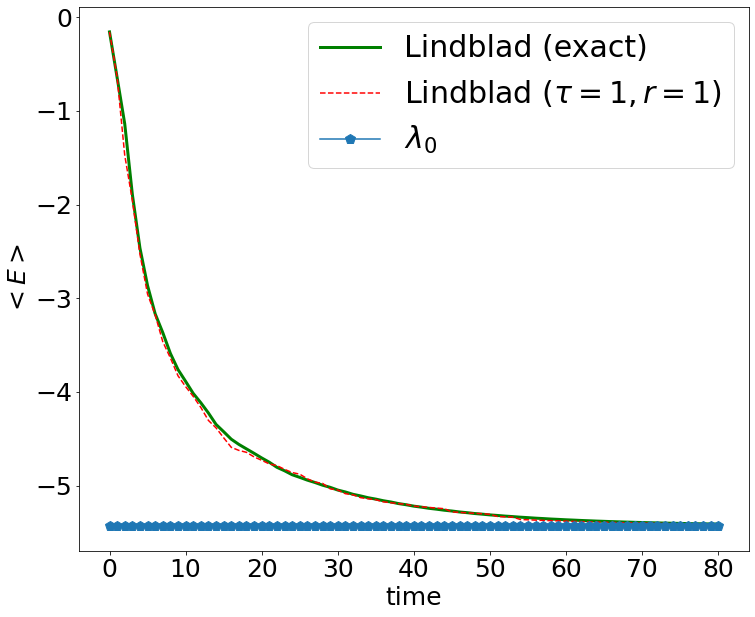

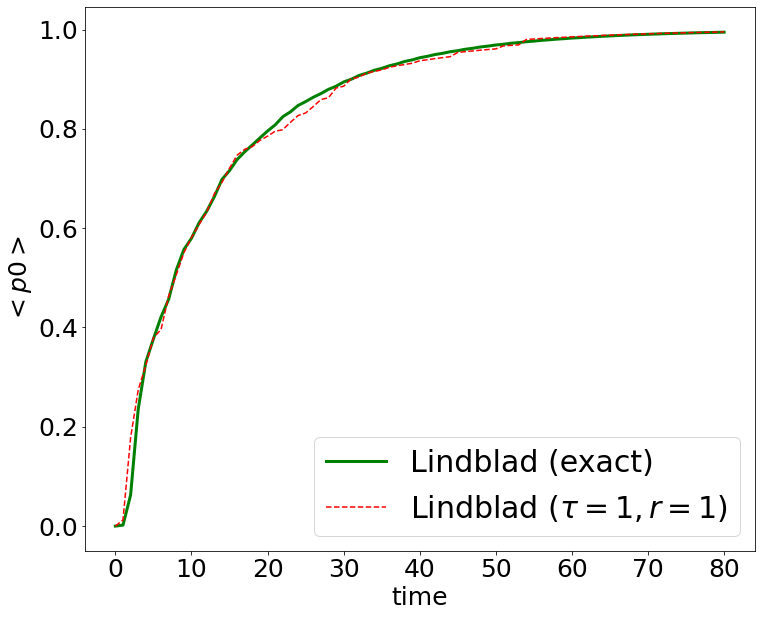

In [6]:
plt.figure(figsize=(12,10))
plt.plot(times, avg_energy_e, 'g-', label='Lindblad (exact)', linewidth=3, markersize=10)
plt.plot(times_l, avg_energy_l, 'r--', label=r'Lindblad $(\tau=1,r=1)$', linewidth=1.5, markersize=10)
plt.plot(times, np.ones_like(times)*E_GS, 'p-', label=r'$\lambda_0$', linewidth=1.5,markersize=10)
plt.legend()
plt.xlabel('time',fontsize=25)
plt.ylabel(r'$<E>$',fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(fontsize=30)
plt.show()

plt.figure(figsize=(12,10))
plt.plot(times, avg_pGS_e,'g-', label=r'Lindblad (exact)', linewidth=3, markersize=20)
plt.plot(times_l, avg_pGS_l, 'r--', label=r'Lindblad $(\tau=1,r=1)$', linewidth=1.5, markersize=10)
plt.legend()
plt.xlabel('time',fontsize=25)
plt.ylabel(r'$<p0>$',fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(fontsize=30,loc="lower right")
plt.show()

In [7]:
#Continuous Lindblad simulation
# avg_energy_s: list of energy
# avg_pGS_s: list of overlap
# time_H_s: list of H simulation time
# rho_all_s: list of rho_n
num_t = 10*num_segment*num_t #small time step
num_segment=1
times_s, avg_energy_s, avg_pGS_s, time_H_s, rho_all_s = lb.Lindblad_simulation(T, num_t,
        num_segment, psi0, num_rep, S_s, M_s,
        psi_GS, intorder=2)

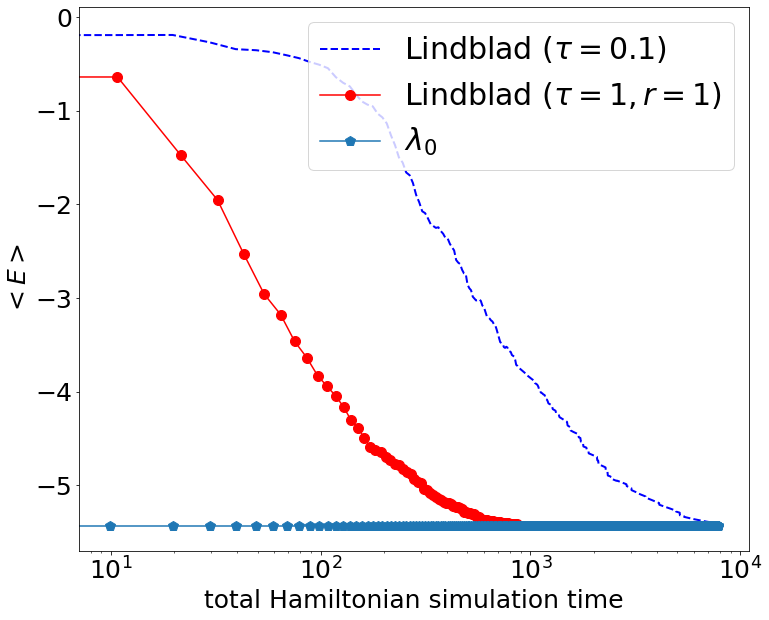

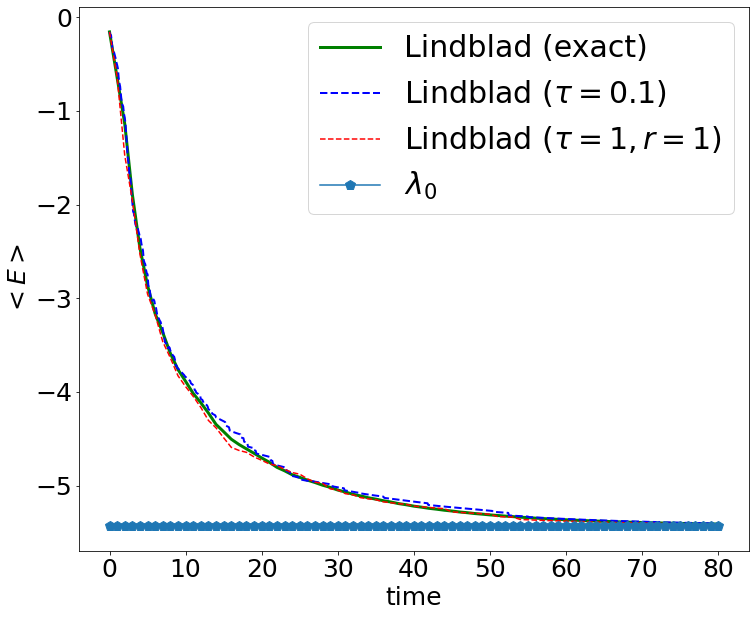

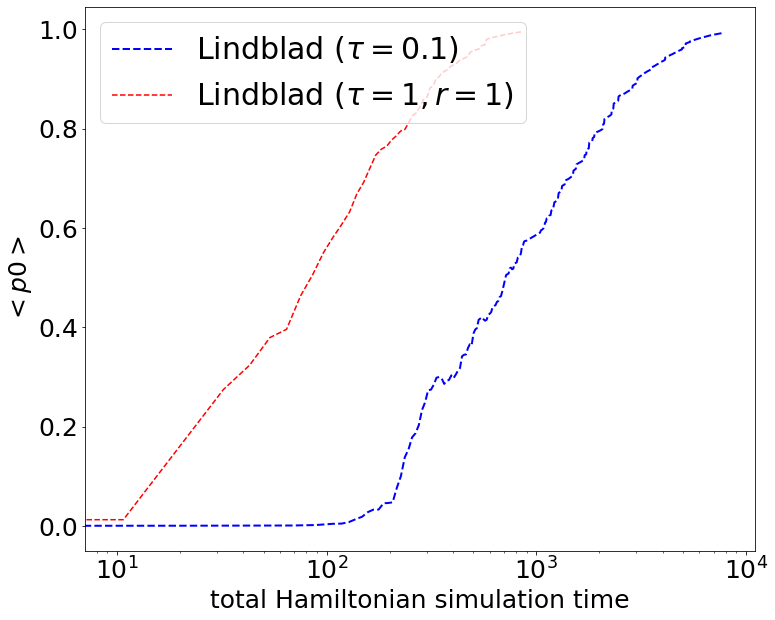

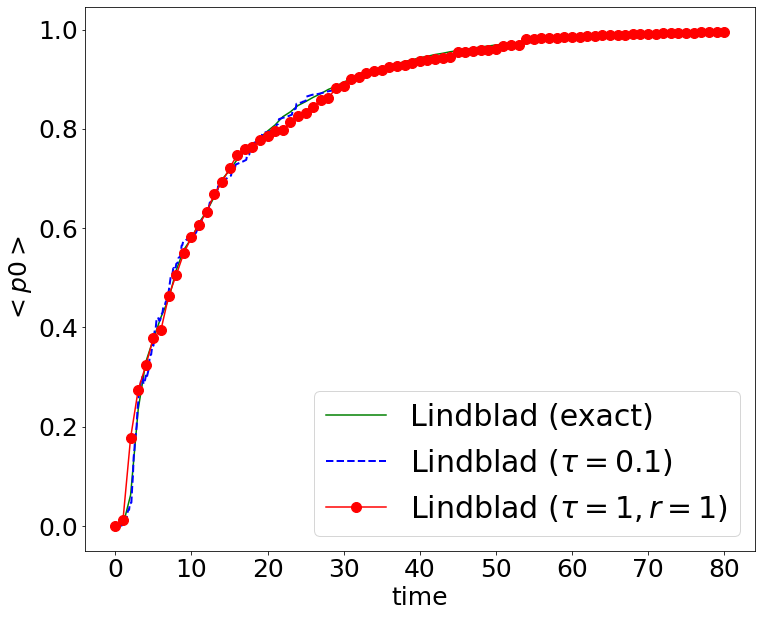

In [8]:
plt.figure(figsize=(12,10))
plt.plot(time_H_s, avg_energy_s,'b--', label=r'Lindblad $(\tau=0.1)$', linewidth=2, markersize=10)
plt.plot(time_H_l, avg_energy_l, 'r-o', label=r'Lindblad $(\tau=1,r=1)$', linewidth=1.5, markersize=10)
plt.plot(time_H_s, np.ones_like(time_H_s)*E_GS, 'p-', label=r'$\lambda_0$', linewidth=1.5,markersize=10)
plt.legend()
plt.xlabel('total Hamiltonian simulation time',fontsize=25)
plt.ylabel(r'$<E>$',fontsize=25)
plt.xscale('log')
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(fontsize=30)
plt.savefig('TFIM_4_energy_H_time.pdf')
plt.show()

plt.figure(figsize=(12,10))
plt.plot(times, avg_energy_e, 'g-', label='Lindblad (exact)', linewidth=3, markersize=10)
plt.plot(times_s, avg_energy_s,'b--', label=r'Lindblad $(\tau=0.1)$', linewidth=2, markersize=10)
plt.plot(times_l, avg_energy_l, 'r--', label=r'Lindblad $(\tau=1,r=1)$', linewidth=1.5, markersize=10)
plt.plot(times, np.ones_like(times)*E_GS, 'p-', label=r'$\lambda_0$', linewidth=1.5,markersize=10)
plt.legend()
plt.xlabel('time',fontsize=25)
plt.ylabel(r'$<E>$',fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(fontsize=30)
plt.savefig('TFIM_4_energy_time.pdf')
plt.show()


plt.figure(figsize=(12,10))
plt.plot(time_H_s, avg_pGS_s,'b--', label=r'Lindblad $(\tau=0.1)$', linewidth=2, markersize=10)
plt.plot(time_H_l, avg_pGS_l, 'r--', label=r'Lindblad $(\tau=1,r=1)$', linewidth=1.5, markersize=10)
plt.legend()
plt.xlabel('total Hamiltonian simulation time',fontsize=25)
plt.ylabel(r'$<p0>$',fontsize=25)
plt.xscale('log')
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(fontsize=30,loc="upper left")
plt.savefig('TFIM_4_overlap_H_time.pdf')
plt.show()

plt.figure(figsize=(12,10))
plt.plot(times, avg_pGS_e, 'g-', label=r'Lindblad (exact)', linewidth=1.5, markersize=10)
plt.plot(times_s, avg_pGS_s,'b--', label=r'Lindblad $(\tau=0.1)$', linewidth=2, markersize=10)
plt.plot(times_l, avg_pGS_l, 'r-o', label=r'Lindblad $(\tau=1,r=1)$', linewidth=1.5, markersize=10)
plt.legend()
plt.xlabel('time',fontsize=25)
plt.ylabel(r'$<p0>$',fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(fontsize=30,loc="lower right")
plt.savefig('TFIM_4_overlap_time.pdf')
plt.show()

# Error check

In [9]:
#continuous simulation error check
num_rep=2000
num_segment=1
num_t = 10*num_segment*int(T)
times_s, avg_energy_s, avg_pGS_s, time_H_s, rho_all_s = lb.Lindblad_simulation(T, num_t,
        num_segment, psi0, num_rep, S_s, M_s,
        psi_GS, intorder=2)
result = mesolve(H_obj, Qobj(psi0), times_s, [Qobj(lb.A_jump)])
error_s=np.zeros(np.int(num_t+1))
for it in range(np.int(num_t+1)):
    error_s[it]=la.norm(result.states[it]-lb.eHT@rho_all_s[:,:,it]@lb.eHT.conj().T, 'nuc')

/var/folders/0k/l2cqwppj67g8y4c4nt5v5q7w0000gn/T/ipykernel_67721/2400518672.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  error_s=np.zeros(np.int(num_t+1))
/var/folders/0k/l2cqwppj67g8y4c4nt5v5q7w0000gn/T/ipykernel_67721/2400518672.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your curren

In [10]:
#discrete simulation error check
num_rep=2000
num_segment=1
num_t = int(T)
times_l, avg_energy_l, avg_pGS_l, time_H_l, rho_all_l = lb.Lindblad_simulation(T, num_t,
        num_segment, psi0, num_rep, S_s, M_s,
        psi_GS, intorder=2)
result = mesolve(H_obj, Qobj(psi0), times_l, [Qobj(lb.A_jump)])
error_l=np.zeros(np.int(num_t+1))
for it in range(np.int(num_t+1)):
    error_l[it]=la.norm(result.states[it]-lb.eHT@rho_all_l[:,:,it]@lb.eHT.conj().T, 'nuc')

/var/folders/0k/l2cqwppj67g8y4c4nt5v5q7w0000gn/T/ipykernel_67721/3118083608.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  error_l=np.zeros(np.int(num_t+1))
/var/folders/0k/l2cqwppj67g8y4c4nt5v5q7w0000gn/T/ipykernel_67721/3118083608.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your curren

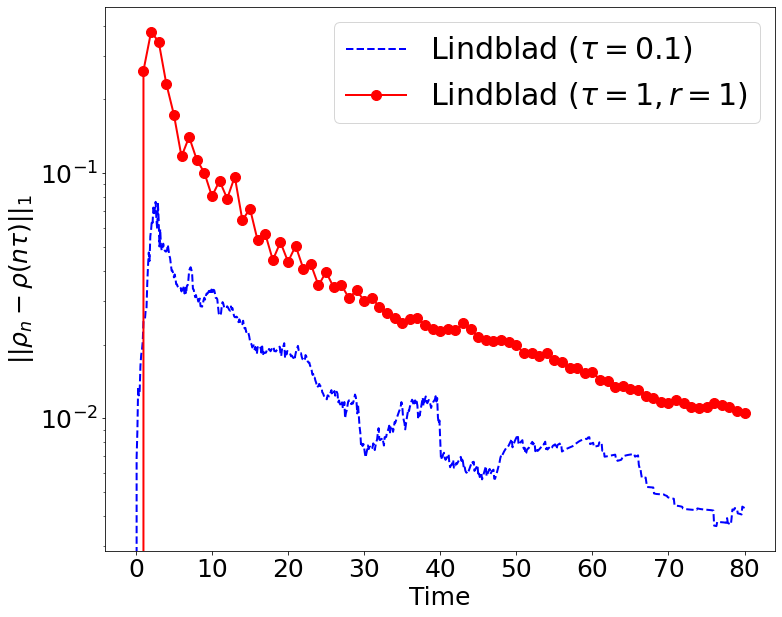

In [11]:
plt.figure(figsize=(12,10))
plt.plot(times_s[:],error_s, 'b--',label=r'Lindblad $(\tau=0.1)$', linewidth=2, markersize=10)
plt.plot(times_l[:],error_l, 'r-o', label=r'Lindblad $(\tau=1,r=1)$', linewidth=2, markersize=10)
plt.yscale('log')
plt.xlabel('Time',fontsize=25)
plt.ylabel(r'$||\rho_n-\rho(n\tau)||_1$',fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(fontsize=30, loc='upper right')
plt.savefig('TFIM_4_error_check.pdf')
plt.show()